# Task 3: Window Soft-Argmax for Semantic Correspondence

This notebook implements the **window soft-argmax** prediction method as described in Zhang et al. [CVPR 2024].

## Key Improvements over Baseline
1. **Sub-pixel precision**: Instead of discrete argmax, we use soft-argmax for refinement
2. **Noise robustness**: Windowed approach reduces sensitivity to local similarity noise
3. **Better PCK at strict thresholds**: Most improvements visible at α=0.05 and α=0.10

## 1. Setup & Imports

In [1]:
# Install dependencies (Colab only)
!pip install -q tqdm pandas matplotlib

In [2]:
import os
import sys
import glob
from tqdm import tqdm
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import torchvision.transforms as transforms
from collections import defaultdict
import pandas as pd

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Download Dataset

In [3]:
# Download SPair-71k dataset
if not os.path.exists('SPair-71k'):
    !wget -q https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
    !tar -xf SPair-71k.tar.gz
    print("Dataset downloaded and extracted!")
else:
    print("Dataset already exists.")

Dataset downloaded and extracted!


## 3. Dataset Class

In [4]:
class SPairDataset(Dataset):
    """SPair-71k dataset for semantic correspondence"""

    CATEGORIES = [
        "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
        "car", "cat", "chair", "cow", "dog", "horse", "motorbike",
        "person", "pottedplant", "sheep", "train", "tvmonitor"
    ]

    CLASS_DICT = {
        'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
        'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
        'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14,
        'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
    }

    def __init__(self, datapath, split='trn', img_size=224, category='all',
                 mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super().__init__()
        assert split in ['trn', 'val', 'test']

        self.split = split
        self.img_size = (img_size, img_size)
        self.max_pts = 20

        base_path = os.path.join(os.path.abspath(datapath), 'SPair-71k')
        self.img_path = os.path.join(base_path, 'JPEGImages')
        self.seg_path = os.path.join(base_path, 'Segmentation')
        self.ann_path = os.path.join(base_path, 'PairAnnotation', split)
        split_file = os.path.join(base_path, 'Layout/large', f'{split}.txt')

        self.train_data = open(split_file).read().strip().split('\n')
        if category != 'all':
            self.train_data = [pair for pair in self.train_data if category in pair]

        self.src_imnames = [x.split('-')[1] + '.jpg' for x in self.train_data]
        self.trg_imnames = [x.split('-')[2].split(':')[0] + '.jpg' for x in self.train_data]
        self.cls = sorted(os.listdir(self.img_path))

        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        print(f"Loading SPair-71k {split} annotations...")
        anntn_files = [glob.glob(f'{self.ann_path}/{name}.json')[0] for name in self.train_data]

        self.src_kps, self.trg_kps = [], []
        self.src_bbox, self.trg_bbox = [], []
        self.cls_ids, self.kps_ids = [], []
        self.vpvar, self.scvar, self.trncn, self.occln = [], [], [], []

        for anntn_file in tqdm(anntn_files):
            with open(anntn_file) as f:
                anntn = json.load(f)
            self.src_kps.append(torch.tensor(anntn['src_kps']).t().float())
            self.trg_kps.append(torch.tensor(anntn['trg_kps']).t().float())
            self.src_bbox.append(torch.tensor(anntn['src_bndbox']).float())
            self.trg_bbox.append(torch.tensor(anntn['trg_bndbox']).float())
            self.cls_ids.append(self.cls.index(anntn['category']))
            self.kps_ids.append(anntn.get('kps_ids', []))
            self.vpvar.append(torch.tensor(anntn['viewpoint_variation']))
            self.scvar.append(torch.tensor(anntn['scale_variation']))
            self.trncn.append(torch.tensor(anntn['truncation']))
            self.occln.append(torch.tensor(anntn['occlusion']))

        self.src_identifiers = [f"{self.cls[ids]}-{name[:-4]}" for ids, name in zip(self.cls_ids, self.src_imnames)]
        self.trg_identifiers = [f"{self.cls[ids]}-{name[:-4]}" for ids, name in zip(self.cls_ids, self.trg_imnames)]

    def __len__(self):
        return len(self.src_imnames)

    def __getitem__(self, idx):
        batch = {}
        batch['src_imname'] = self.src_imnames[idx]
        batch['trg_imname'] = self.trg_imnames[idx]
        batch['category_id'] = self.cls_ids[idx]
        batch['category'] = self.cls[batch['category_id']]
        batch['pair_idx'] = idx

        src_pil = self._get_image(self.src_imnames[idx], batch['category_id'])
        trg_pil = self._get_image(self.trg_imnames[idx], batch['category_id'])
        batch['src_imsize'] = src_pil.size
        batch['trg_imsize'] = trg_pil.size

        batch['src_img'] = self.transform(src_pil)
        batch['trg_img'] = self.transform(trg_pil)

        h1, w1 = batch['src_img'].shape[1:]
        h2, w2 = batch['trg_img'].shape[1:]

        batch['src_mask'] = self._get_mask(batch['category'], batch['src_imname'], (h1, w1))
        batch['trg_mask'] = self._get_mask(batch['category'], batch['trg_imname'], (h2, w2))
        batch['src_bbox'] = self._scale_bbox(self.src_bbox[idx], batch['src_imsize'], (h1, w1))
        batch['trg_bbox'] = self._scale_bbox(self.trg_bbox[idx], batch['trg_imsize'], (h2, w2))

        batch['src_kps'], num_pts = self._get_points(self.src_kps[idx], batch['src_imsize'], (h1, w1))
        batch['trg_kps'], _ = self._get_points(self.trg_kps[idx], batch['trg_imsize'], (h2, w2))
        batch['n_pts'] = torch.tensor(num_pts)

        batch['src_kps'] = batch['src_kps'].permute(1, 0)
        batch['trg_kps'] = batch['trg_kps'].permute(1, 0)

        batch['src_kps'][:num_pts] = self._regularise_coordinates(batch['src_kps'][:num_pts], h1, w1, eps=1e-4)
        batch['trg_kps'][:num_pts] = self._regularise_coordinates(batch['trg_kps'][:num_pts], h2, w2, eps=1e-4)

        kps_ids = self.kps_ids[idx][:num_pts]
        padded_kps_ids = kps_ids + ["-1"] * (self.max_pts - len(kps_ids))
        batch['kps_ids'] = padded_kps_ids

        batch['src_pckthres'] = self._get_pckthres(batch['src_bbox'])
        batch['trg_pckthres'] = self._get_pckthres(batch['trg_bbox'])
        batch['pckthres'] = batch['trg_pckthres'].clone()

        batch['vpvar'] = self.vpvar[idx]
        batch['scvar'] = self.scvar[idx]
        batch['trncn'] = self.trncn[idx]
        batch['occln'] = self.occln[idx]
        batch['src_identifier'] = self.src_identifiers[idx]
        batch['trg_identifier'] = self.trg_identifiers[idx]
        batch['datalen'] = len(self.train_data)

        return batch

    def _get_image(self, imname, cls_id):
        path = os.path.join(self.img_path, self.cls[cls_id], imname)
        return Image.open(path).convert('RGB')

    def _get_mask(self, category, imname, scaled_imsize):
        mask_path = os.path.join(self.seg_path, category, imname.split('.')[0] + '.png')
        tensor_mask = torch.tensor(np.array(Image.open(mask_path)))
        class_id = self.CLASS_DICT[category] + 1
        tensor_mask = (tensor_mask == class_id).float() * 255
        tensor_mask = F.interpolate(
            tensor_mask.unsqueeze(0).unsqueeze(0), size=scaled_imsize,
            mode='bilinear', align_corners=True
        ).int().squeeze()
        return tensor_mask

    def _scale_bbox(self, bbox, ori_imsize, scaled_imsize):
        bbox = bbox.clone()
        bbox[0::2] *= scaled_imsize[1] / ori_imsize[0]
        bbox[1::2] *= scaled_imsize[0] / ori_imsize[1]
        return bbox

    def _get_points(self, pts, ori_imsize, scaled_imsize):
        xy, n_pts = pts.size()
        pad_pts = torch.zeros((xy, self.max_pts - n_pts)) - 2
        x_crds = pts[0] * (scaled_imsize[1] / ori_imsize[0])
        y_crds = pts[1] * (scaled_imsize[0] / ori_imsize[1])
        kps = torch.cat([torch.stack([x_crds, y_crds]), pad_pts], dim=1)
        return kps, n_pts

    def _get_pckthres(self, bbox):
        if len(bbox.shape) == 2:
            bbox = bbox.squeeze(0)
        bbox_w = bbox[2] - bbox[0]
        bbox_h = bbox[3] - bbox[1]
        return torch.max(bbox_w, bbox_h).float()

    def _regularise_coordinates(self, coord, H, W, eps=0):
        coord = coord.clone()
        coord[..., 0] = torch.clamp(coord[..., 0], min=0+eps, max=W-1-eps)
        coord[..., 1] = torch.clamp(coord[..., 1], min=0+eps, max=H-1-eps)
        return coord

## 4. Feature Extractor

In [5]:
class DINOv2Extractor:
    def __init__(self, model_name="dinov2_vitb14"):
        self.model = torch.hub.load("facebookresearch/dinov2", model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()
        self.patch_size = self.model.patch_size

    @torch.no_grad()
    def extract(self, img: torch.Tensor):
        if img.dim() == 3:
            img = img.unsqueeze(0)
        B, C, H, W = img.shape
        img = img.to(self.device)
        out = self.model.forward_features(img)
        features = out["x_norm_patchtokens"]
        H_p = H // self.patch_size
        W_p = W // self.patch_size
        return features, (H_p, W_p)

## 5. Correspondence Matchers

### 5.1 Baseline (Argmax)

In [6]:
class CorrespondenceMatcher:
    """Baseline matcher using argmax"""

    def __init__(self, feature_extractor):
        self.extractor = feature_extractor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def find_correspondences(self, src_img, trg_img, src_kps):
        is_batched = src_img.dim() == 4
        if not is_batched:
            src_img = src_img.unsqueeze(0)
            trg_img = trg_img.unsqueeze(0)
            src_kps = src_kps.unsqueeze(0)

        src_img = src_img.to(self.device)
        trg_img = trg_img.to(self.device)
        src_kps = src_kps.to(self.device)

        B, N, _ = src_kps.shape
        src_feats, (h_p, w_p) = self.extractor.extract(src_img)
        trg_feats, _ = self.extractor.extract(trg_img)

        D = src_feats.shape[-1]
        patch_size = self.extractor.patch_size

        src_feats = F.normalize(src_feats, dim=-1)
        trg_feats = F.normalize(trg_feats, dim=-1)

        valid_mask = (src_kps[..., 0] >= 0)
        kps_grid = (src_kps / patch_size).long()
        grid_x = kps_grid[..., 0].clamp(0, w_p - 1)
        grid_y = kps_grid[..., 1].clamp(0, h_p - 1)
        flat_indices = grid_y * w_p + grid_x

        flat_indices_expanded = flat_indices.unsqueeze(-1).expand(-1, -1, D)
        src_kp_feats = torch.gather(src_feats, 1, flat_indices_expanded)

        sim_matrix = torch.bmm(src_kp_feats, trg_feats.transpose(1, 2))
        best_match_indices = torch.argmax(sim_matrix, dim=-1)

        pred_y_idx = best_match_indices // w_p
        pred_x_idx = best_match_indices % w_p

        pred_x_px = (pred_x_idx.float() + 0.5) * patch_size
        pred_y_px = (pred_y_idx.float() + 0.5) * patch_size

        pred_kps = torch.stack([pred_x_px, pred_y_px], dim=-1)
        pred_kps[~valid_mask] = -2

        if not is_batched:
            pred_kps = pred_kps.squeeze(0)

        return pred_kps

### 5.2 Window Soft-Argmax (Task 3)

In [7]:
class WindowSoftArgmaxMatcher:
    """
    Correspondence matcher using window soft-argmax for sub-pixel refinement.

    Key improvements:
    1. Find peak location with argmax (discrete)
    2. Apply soft-argmax within a small window around the peak
    3. Sub-pixel precision and robustness to noise
    """

    def __init__(self, feature_extractor, window_size=5, temperature=0.1):
        self.extractor = feature_extractor
        self.window_size = window_size
        self.temperature = temperature
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def find_correspondences(self, src_img, trg_img, src_kps):
        is_batched = src_img.dim() == 4
        if not is_batched:
            src_img = src_img.unsqueeze(0)
            trg_img = trg_img.unsqueeze(0)
            src_kps = src_kps.unsqueeze(0)

        src_img = src_img.to(self.device)
        trg_img = trg_img.to(self.device)
        src_kps = src_kps.to(self.device)

        B, N, _ = src_kps.shape
        src_feats, (h_p, w_p) = self.extractor.extract(src_img)
        trg_feats, _ = self.extractor.extract(trg_img)

        D = src_feats.shape[-1]
        patch_size = self.extractor.patch_size

        src_feats = F.normalize(src_feats, dim=-1)
        trg_feats = F.normalize(trg_feats, dim=-1)

        valid_mask = (src_kps[..., 0] >= 0)
        kps_grid = (src_kps / patch_size).long()
        grid_x = kps_grid[..., 0].clamp(0, w_p - 1)
        grid_y = kps_grid[..., 1].clamp(0, h_p - 1)
        flat_indices = grid_y * w_p + grid_x

        flat_indices_expanded = flat_indices.unsqueeze(-1).expand(-1, -1, D)
        src_kp_feats = torch.gather(src_feats, 1, flat_indices_expanded)

        sim_matrix = torch.bmm(src_kp_feats, trg_feats.transpose(1, 2))
        sim_grid = sim_matrix.view(B, N, h_p, w_p)

        pred_kps = self._window_soft_argmax(sim_grid, patch_size)
        pred_kps[~valid_mask] = -2

        if not is_batched:
            pred_kps = pred_kps.squeeze(0)

        return pred_kps

    def _window_soft_argmax(self, sim_grid, patch_size):
        """Apply window soft-argmax for sub-pixel refinement"""
        B, N, h_p, w_p = sim_grid.shape
        half_window = self.window_size // 2

        sim_flat = sim_grid.view(B, N, -1)
        peak_indices = torch.argmax(sim_flat, dim=-1)

        peak_y = peak_indices // w_p
        peak_x = peak_indices % w_p

        pred_kps = torch.zeros(B, N, 2, device=sim_grid.device, dtype=torch.float32)

        for b in range(B):
            for n in range(N):
                py = peak_y[b, n].item()
                px = peak_x[b, n].item()

                y_min = max(0, py - half_window)
                y_max = min(h_p, py + half_window + 1)
                x_min = max(0, px - half_window)
                x_max = min(w_p, px + half_window + 1)

                window = sim_grid[b, n, y_min:y_max, x_min:x_max]
                window_flat = window.flatten() / self.temperature
                weights = F.softmax(window_flat, dim=0)

                h_w, w_w = window.shape
                y_coords = torch.arange(y_min, y_max, device=sim_grid.device, dtype=torch.float32)
                x_coords = torch.arange(x_min, x_max, device=sim_grid.device, dtype=torch.float32)

                yy, xx = torch.meshgrid(y_coords, x_coords, indexing='ij')
                yy_flat = yy.flatten()
                xx_flat = xx.flatten()

                pred_y_patch = (weights * yy_flat).sum()
                pred_x_patch = (weights * xx_flat).sum()

                pred_kps[b, n, 0] = (pred_x_patch + 0.5) * patch_size
                pred_kps[b, n, 1] = (pred_y_patch + 0.5) * patch_size

        return pred_kps

## 6. Evaluator

In [8]:
class CorrespondenceEvaluator:
    """Evaluates semantic correspondence using PCK metric"""

    def __init__(self, thresholds=[0.05, 0.10, 0.15, 0.20]):
        self.thresholds = thresholds
        self.reset()

    def reset(self):
        self.overall = {t: [0, 0] for t in self.thresholds}
        self.per_keypoint = defaultdict(lambda: {t: [0, 0] for t in self.thresholds})
        self.per_image = defaultdict(lambda: {t: [0, 0] for t in self.thresholds})
        self.per_category = defaultdict(lambda: {t: [0, 0] for t in self.thresholds})

    def compute_pck(self, pred_kps, gt_kps, threshold_value, n_pts):
        distances = torch.norm(pred_kps - gt_kps, dim=1)
        correct = (distances < threshold_value).float()
        correct[n_pts:] = 0
        distances[n_pts:] = float('inf')
        return correct, distances

    def update(self, pred_kps, batch):
        gt_kps = batch['trg_kps']
        n_pts = batch['n_pts'].item()
        pck_thres = batch['pckthres'].item()
        kps_ids = batch['kps_ids']
        pair_idx = batch['pair_idx']
        category = batch['category']

        if isinstance(kps_ids, tuple):
            kps_ids = list(kps_ids)

        pred_kps = pred_kps.to(gt_kps.device)

        for alpha in self.thresholds:
            threshold_value = alpha * pck_thres
            correct, distances = self.compute_pck(pred_kps, gt_kps, threshold_value, n_pts)
            n_correct = correct[:n_pts].sum().item()

            self.overall[alpha][0] += n_correct
            self.overall[alpha][1] += n_pts
            self.per_image[pair_idx][alpha][0] += n_correct
            self.per_image[pair_idx][alpha][1] += n_pts
            self.per_category[category][alpha][0] += n_correct
            self.per_category[category][alpha][1] += n_pts

            for kp_idx in range(n_pts):
                kp_id = kps_ids[kp_idx]
                if isinstance(kp_id, tuple):
                    kp_id = kp_id[0]
                if kp_id != "-1":
                    kp_key = (category, kp_id)
                    is_correct = correct[kp_idx].item()
                    self.per_keypoint[kp_key][alpha][0] += is_correct
                    self.per_keypoint[kp_key][alpha][1] += 1

    def get_metrics(self):
        metrics = {'overall': {}, 'per_keypoint': {}, 'per_image': {}, 'per_category': {}}

        for alpha in self.thresholds:
            correct, total = self.overall[alpha]
            metrics['overall'][alpha] = 100.0 * correct / total if total > 0 else 0.0

        for (category, kp_id), results in self.per_keypoint.items():
            if category not in metrics['per_keypoint']:
                metrics['per_keypoint'][category] = {}
            metrics['per_keypoint'][category][kp_id] = {}
            for alpha in self.thresholds:
                correct, total = results[alpha]
                metrics['per_keypoint'][category][kp_id][alpha] = 100.0 * correct / total if total > 0 else 0.0

        for pair_idx, results in self.per_image.items():
            metrics['per_image'][pair_idx] = {}
            for alpha in self.thresholds:
                correct, total = results[alpha]
                metrics['per_image'][pair_idx][alpha] = 100.0 * correct / total if total > 0 else 0.0

        for category, results in self.per_category.items():
            metrics['per_category'][category] = {}
            for alpha in self.thresholds:
                correct, total = results[alpha]
                metrics['per_category'][category][alpha] = 100.0 * correct / total if total > 0 else 0.0

        return metrics

    def print_summary(self, metrics=None):
        if metrics is None:
            metrics = self.get_metrics()

        print("\n" + "="*70)
        print("EVALUATION SUMMARY")
        print("="*70)

        print("\n📊 Overall PCK:")
        print("-" * 70)
        for alpha in self.thresholds:
            pck = metrics['overall'][alpha]
            print(f"  PCK@{alpha:.2f}: {pck:.2f}%")

        print("\n📁 Per-Category PCK:")
        print("-" * 70)
        for category in sorted(metrics['per_category'].keys()):
            pck_str = " | ".join([f"{alpha:.2f}: {metrics['per_category'][category][alpha]:.2f}%"
                                   for alpha in self.thresholds])
            print(f"  {category:15s} → {pck_str}")

        print("\n" + "="*70)

In [13]:
def evaluate_model(matcher, dataloader, desc="Evaluating"):
    """Evaluate correspondence matcher on a dataset."""
    evaluator = CorrespondenceEvaluator(thresholds=[0.05, 0.10, 0.15, 0.20])
    matcher.extractor.model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc):
            src_img = batch['src_img']
            trg_img = batch['trg_img']
            src_kps = batch['src_kps']

            pred_kps = matcher.find_correspondences(src_img, trg_img, src_kps)

            batch_size = src_img.shape[0]
            for b in range(batch_size):
                pred_kps_b = pred_kps[b]
                # kps_ids is collated as list[max_pts] of tuples[batch_size]
                # Extract the b-th element from each tuple to get per-sample IDs
                kps_ids_b = [kp_tuple[b] if isinstance(kp_tuple, tuple) else kp_tuple for kp_tuple in batch['kps_ids']]
                batch_single = {
                    'trg_kps': batch['trg_kps'][b],
                    'pckthres': batch['pckthres'][b],
                    'n_pts': batch['n_pts'][b],
                    'kps_ids': kps_ids_b,  # ✅ Now correctly extracts sample b's keypoint IDs
                    'pair_idx': batch['pair_idx'][b],
                    'category': batch['category'][b],
                }
                evaluator.update(pred_kps_b, batch_single)

    metrics = evaluator.get_metrics()
    evaluator.print_summary(metrics)

    return metrics

## 7. Run Experiments

In [14]:
# Load dataset
DATA_PATH = '.'  # Path where SPair-71k was extracted

test_dataset = SPairDataset(DATA_PATH, split='test', img_size=224)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Test dataset: {len(test_dataset)} pairs")

Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:01<00:00, 7073.33it/s]

Test dataset: 12234 pairs


In [15]:
# Load feature extractor
print("Loading DINOv2...")
extractor = DINOv2Extractor(model_name="dinov2_vitb14")
print("Model loaded!")

Loading DINOv2...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Model loaded!


### 7.1 Baseline Argmax Evaluation

In [16]:
# Baseline matcher (argmax)
baseline_matcher = CorrespondenceMatcher(extractor)

print("\n" + "="*70)
print("BASELINE (ARGMAX)")
print("="*70)
baseline_metrics = evaluate_model(baseline_matcher, test_loader, desc="Baseline")


BASELINE (ARGMAX)


Baseline: 100%|██████████| 1530/1530 [07:17<00:00,  3.50it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 20.37%
  PCK@0.10: 42.46%
  PCK@0.15: 55.20%
  PCK@0.20: 63.81%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 32.66% | 0.10: 58.60% | 0.15: 69.77% | 0.20: 77.84%
  bicycle         → 0.05: 22.68% | 0.10: 49.22% | 0.15: 61.61% | 0.20: 69.24%
  bird            → 0.05: 31.49% | 0.10: 66.47% | 0.15: 80.68% | 0.20: 87.83%
  boat            → 0.05: 10.78% | 0.10: 26.28% | 0.15: 39.49% | 0.20: 47.67%
  bottle          → 0.05: 13.75% | 0.10: 32.56% | 0.15: 44.21% | 0.20: 52.85%
  bus             → 0.05: 16.70% | 0.10: 34.75% | 0.15: 44.64% | 0.20: 51.76%
  car             → 0.05: 18.49% | 0.10: 38.14% | 0.15: 49.44% | 0.20: 56.57%
  cat             → 0.05: 39.03% | 0.10: 62.42% | 0.15: 71.56% | 0.20: 77.61%
  chair           → 0.05: 12.65% | 0.10: 27.82% | 0.15: 39.05% | 0.20: 48.41%
  cow             → 0.0

### 7.2 Window Soft-Argmax Evaluation

In [17]:
# Window Soft-Argmax matcher
softargmax_matcher = WindowSoftArgmaxMatcher(
    extractor,
    window_size=5,
    temperature=0.1
)

print("\n" + "="*70)
print("WINDOW SOFT-ARGMAX (window=5, temp=0.1)")
print("="*70)
softargmax_metrics = evaluate_model(softargmax_matcher, test_loader, desc="Soft-Argmax")


WINDOW SOFT-ARGMAX (window=5, temp=0.1)


Soft-Argmax: 100%|██████████| 1530/1530 [08:37<00:00,  2.96it/s]


EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 21.27%
  PCK@0.10: 44.38%
  PCK@0.15: 58.25%
  PCK@0.20: 66.89%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 32.24% | 0.10: 60.85% | 0.15: 72.12% | 0.20: 79.04%
  bicycle         → 0.05: 26.02% | 0.10: 51.14% | 0.15: 64.30% | 0.20: 73.00%
  bird            → 0.05: 39.65% | 0.10: 73.25% | 0.15: 84.91% | 0.20: 89.74%
  boat            → 0.05: 9.98% | 0.10: 25.69% | 0.15: 39.34% | 0.20: 49.91%
  bottle          → 0.05: 11.38% | 0.10: 33.39% | 0.15: 46.15% | 0.20: 55.50%
  bus             → 0.05: 15.81% | 0.10: 34.99% | 0.15: 46.52% | 0.20: 54.33%
  car             → 0.05: 20.94% | 0.10: 40.48% | 0.15: 51.64% | 0.20: 58.63%
  cat             → 0.05: 41.16% | 0.10: 67.47% | 0.15: 76.56% | 0.20: 81.83%
  chair           → 0.05: 7.09% | 0.10: 22.15% | 0.15: 40.14% | 0.20: 52.11%
  cow             → 0.05:

## 8. Compare Results

In [18]:
# Create comparison table
print("\n" + "="*70)
print("COMPARISON: BASELINE vs SOFT-ARGMAX")
print("="*70)

thresholds = [0.05, 0.10, 0.15, 0.20]

comparison_data = {
    'Threshold': thresholds,
    'Baseline (Argmax)': [baseline_metrics['overall'][t] for t in thresholds],
    'Soft-Argmax': [softargmax_metrics['overall'][t] for t in thresholds],
}
comparison_data['Δ Improvement'] = [
    comparison_data['Soft-Argmax'][i] - comparison_data['Baseline (Argmax)'][i]
    for i in range(len(thresholds))
]

df = pd.DataFrame(comparison_data)
df['Threshold'] = df['Threshold'].apply(lambda x: f'PCK@{x:.2f}')
print(df.to_string(index=False))


COMPARISON: BASELINE vs SOFT-ARGMAX
Threshold  Baseline (Argmax)  Soft-Argmax  Δ Improvement
 PCK@0.05          20.368400    21.266190       0.897790
 PCK@0.10          42.459922    44.383434       1.923512
 PCK@0.15          55.196540    58.249932       3.053392
 PCK@0.20          63.814419    66.890454       3.076035


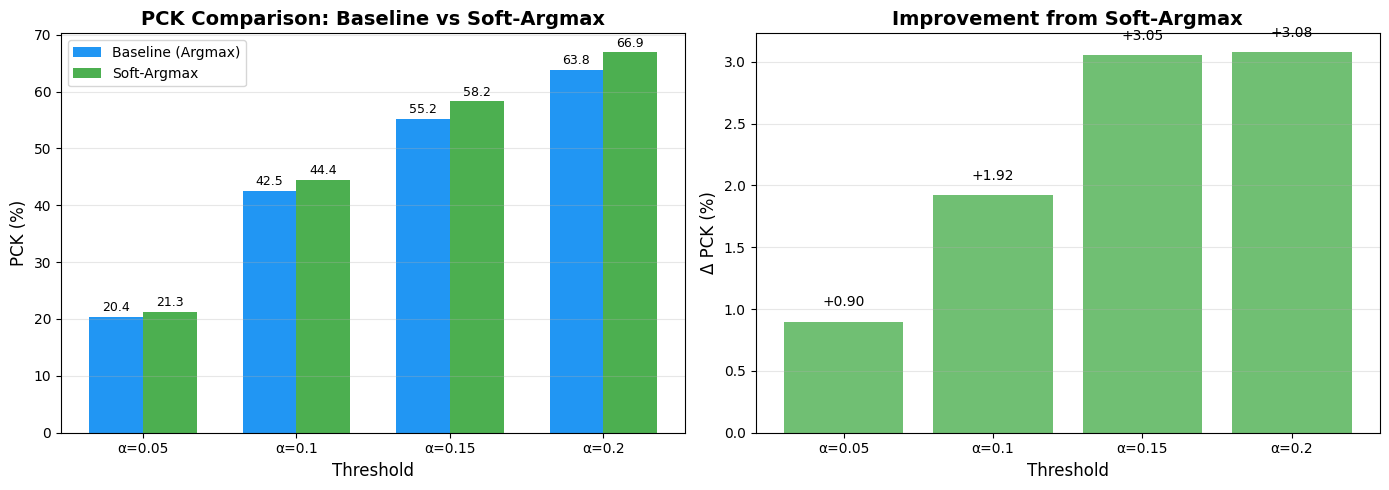


📊 Comparison plot saved as 'task3_comparison.png'


In [19]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCK comparison
ax1 = axes[0]
x = np.arange(len(thresholds))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_data['Baseline (Argmax)'], width, label='Baseline (Argmax)', color='#2196F3')
bars2 = ax1.bar(x + width/2, comparison_data['Soft-Argmax'], width, label='Soft-Argmax', color='#4CAF50')

ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('PCK (%)', fontsize=12)
ax1.set_title('PCK Comparison: Baseline vs Soft-Argmax', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'α={t}' for t in thresholds])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)

# Improvement plot
ax2 = axes[1]
colors = ['#4CAF50' if d >= 0 else '#f44336' for d in comparison_data['Δ Improvement']]
bars = ax2.bar(x, comparison_data['Δ Improvement'], color=colors, alpha=0.8)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Δ PCK (%)', fontsize=12)
ax2.set_title('Improvement from Soft-Argmax', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'α={t}' for t in thresholds])
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:+.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('task3_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Comparison plot saved as 'task3_comparison.png'")

## 9. Ablation: Window Size & Temperature

In [ ]:
# Test different hyperparameters
window_sizes = [3, 5, 7]
temperatures = [0.05, 0.1, 0.2]

ablation_results = []

for ws in window_sizes:
    for temp in temperatures:
        print(f"\nTesting window_size={ws}, temperature={temp}...")
        matcher = WindowSoftArgmaxMatcher(extractor, window_size=ws, temperature=temp)
        metrics = evaluate_model(matcher, test_loader, desc=f"ws={ws}, t={temp}")

        ablation_results.append({
            'window_size': ws,
            'temperature': temp,
            'PCK@0.05': metrics['overall'][0.05],
            'PCK@0.10': metrics['overall'][0.10],
            'PCK@0.15': metrics['overall'][0.15],
            'PCK@0.20': metrics['overall'][0.20],
        })

ablation_df = pd.DataFrame(ablation_results)
print("\n" + "="*70)
print("ABLATION STUDY: WINDOW SIZE & TEMPERATURE")
print("="*70)
print(ablation_df.to_string(index=False))
ablation_df.to_csv('task3_ablation.csv', index=False)
print("\n📊 Ablation results saved as 'task3_ablation.csv'")


Testing window_size=3, temperature=0.05...


ws=3, t=0.05: 100%|██████████| 1530/1530 [08:36<00:00,  2.96it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 24.09%
  PCK@0.10: 45.22%
  PCK@0.15: 57.02%
  PCK@0.20: 65.05%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 37.33% | 0.10: 60.83% | 0.15: 69.90% | 0.20: 77.99%
  bicycle         → 0.05: 31.20% | 0.10: 52.59% | 0.15: 63.06% | 0.20: 70.74%
  bird            → 0.05: 40.16% | 0.10: 71.48% | 0.15: 82.84% | 0.20: 88.89%
  boat            → 0.05: 11.61% | 0.10: 27.91% | 0.15: 40.08% | 0.20: 48.76%
  bottle          → 0.05: 15.21% | 0.10: 34.26% | 0.15: 45.48% | 0.20: 53.91%
  bus             → 0.05: 18.87% | 0.10: 36.60% | 0.15: 46.05% | 0.20: 53.13%
  car             → 0.05: 22.16% | 0.10: 40.84% | 0.15: 50.84% | 0.20: 57.46%
  cat             → 0.05: 46.89% | 0.10: 64.91% | 0.15: 72.56% | 0.20: 78.33%
  chair           → 0.05: 12.16% | 0.10: 27.90% | 0.15: 41.70% | 0.20: 49.56%
  cow             → 0.0

ws=3, t=0.1: 100%|██████████| 1530/1530 [08:34<00:00,  2.98it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 24.26%
  PCK@0.10: 45.37%
  PCK@0.15: 57.14%
  PCK@0.20: 65.21%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 37.50% | 0.10: 60.87% | 0.15: 70.19% | 0.20: 78.14%
  bicycle         → 0.05: 29.69% | 0.10: 52.46% | 0.15: 63.24% | 0.20: 70.80%
  bird            → 0.05: 40.59% | 0.10: 71.73% | 0.15: 82.80% | 0.20: 88.89%
  boat            → 0.05: 11.81% | 0.10: 27.88% | 0.15: 40.02% | 0.20: 48.73%
  bottle          → 0.05: 14.65% | 0.10: 34.57% | 0.15: 45.61% | 0.20: 53.85%
  bus             → 0.05: 18.94% | 0.10: 36.69% | 0.15: 46.14% | 0.20: 53.01%
  car             → 0.05: 22.55% | 0.10: 40.95% | 0.15: 50.78% | 0.20: 57.80%
  cat             → 0.05: 47.32% | 0.10: 65.38% | 0.15: 72.85% | 0.20: 78.77%
  chair           → 0.05: 11.83% | 0.10: 27.98% | 0.15: 41.48% | 0.20: 49.84%
  cow             → 0.0

ws=3, t=0.2: 100%|██████████| 1530/1530 [08:34<00:00,  2.98it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 23.46%
  PCK@0.10: 44.92%
  PCK@0.15: 56.83%
  PCK@0.20: 65.04%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 36.57% | 0.10: 60.40% | 0.15: 70.12% | 0.20: 78.04%
  bicycle         → 0.05: 28.04% | 0.10: 51.84% | 0.15: 62.80% | 0.20: 70.62%
  bird            → 0.05: 38.43% | 0.10: 70.93% | 0.15: 82.43% | 0.20: 88.91%
  boat            → 0.05: 11.72% | 0.10: 27.50% | 0.15: 39.81% | 0.20: 48.49%
  bottle          → 0.05: 14.23% | 0.10: 34.44% | 0.15: 45.31% | 0.20: 53.55%
  bus             → 0.05: 18.47% | 0.10: 36.60% | 0.15: 45.87% | 0.20: 52.84%
  car             → 0.05: 21.60% | 0.10: 40.73% | 0.15: 50.45% | 0.20: 57.71%
  cat             → 0.05: 45.63% | 0.10: 64.89% | 0.15: 72.81% | 0.20: 79.14%
  chair           → 0.05: 12.10% | 0.10: 27.77% | 0.15: 41.05% | 0.20: 49.51%
  cow             → 0.0

ws=5, t=0.05: 100%|██████████| 1530/1530 [08:33<00:00,  2.98it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 22.68%
  PCK@0.10: 45.03%
  PCK@0.15: 58.29%
  PCK@0.20: 66.72%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 35.06% | 0.10: 61.32% | 0.15: 72.03% | 0.20: 79.01%
  bicycle         → 0.05: 29.13% | 0.10: 52.51% | 0.15: 64.56% | 0.20: 72.32%
  bird            → 0.05: 40.13% | 0.10: 73.32% | 0.15: 84.84% | 0.20: 89.56%
  boat            → 0.05: 10.69% | 0.10: 26.73% | 0.15: 39.93% | 0.20: 50.18%
  bottle          → 0.05: 13.75% | 0.10: 34.07% | 0.15: 46.39% | 0.20: 55.59%
  bus             → 0.05: 17.62% | 0.10: 36.00% | 0.15: 46.69% | 0.20: 54.29%
  car             → 0.05: 21.77% | 0.10: 40.65% | 0.15: 51.70% | 0.20: 58.18%
  cat             → 0.05: 44.11% | 0.10: 66.99% | 0.15: 75.78% | 0.20: 81.43%
  chair           → 0.05: 8.46% | 0.10: 23.74% | 0.15: 40.94% | 0.20: 52.08%
  cow             → 0.05

ws=5, t=0.1: 100%|██████████| 1530/1530 [08:32<00:00,  2.98it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 21.27%
  PCK@0.10: 44.38%
  PCK@0.15: 58.25%
  PCK@0.20: 66.89%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 32.24% | 0.10: 60.85% | 0.15: 72.12% | 0.20: 79.04%
  bicycle         → 0.05: 26.02% | 0.10: 51.14% | 0.15: 64.30% | 0.20: 73.00%
  bird            → 0.05: 39.65% | 0.10: 73.25% | 0.15: 84.91% | 0.20: 89.74%
  boat            → 0.05: 9.98% | 0.10: 25.69% | 0.15: 39.34% | 0.20: 49.91%
  bottle          → 0.05: 11.38% | 0.10: 33.39% | 0.15: 46.15% | 0.20: 55.50%
  bus             → 0.05: 15.81% | 0.10: 34.99% | 0.15: 46.52% | 0.20: 54.33%
  car             → 0.05: 20.94% | 0.10: 40.48% | 0.15: 51.64% | 0.20: 58.63%
  cat             → 0.05: 41.16% | 0.10: 67.47% | 0.15: 76.56% | 0.20: 81.83%
  chair           → 0.05: 7.09% | 0.10: 22.15% | 0.15: 40.14% | 0.20: 52.11%
  cow             → 0.05:

ws=5, t=0.2: 100%|██████████| 1530/1530 [08:33<00:00,  2.98it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 20.38%
  PCK@0.10: 43.79%
  PCK@0.15: 57.62%
  PCK@0.20: 66.26%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 30.28% | 0.10: 60.16% | 0.15: 71.54% | 0.20: 78.72%
  bicycle         → 0.05: 24.50% | 0.10: 49.82% | 0.15: 63.58% | 0.20: 72.53%
  bird            → 0.05: 37.07% | 0.10: 72.13% | 0.15: 84.25% | 0.20: 89.40%
  boat            → 0.05: 9.92% | 0.10: 25.78% | 0.15: 39.66% | 0.20: 49.20%
  bottle          → 0.05: 10.18% | 0.10: 33.32% | 0.15: 45.87% | 0.20: 54.67%
  bus             → 0.05: 15.65% | 0.10: 33.94% | 0.15: 45.80% | 0.20: 54.22%
  car             → 0.05: 19.57% | 0.10: 40.26% | 0.15: 51.22% | 0.20: 58.41%
  cat             → 0.05: 40.01% | 0.10: 65.99% | 0.15: 75.81% | 0.20: 81.40%
  chair           → 0.05: 7.94% | 0.10: 24.12% | 0.15: 39.81% | 0.20: 51.04%
  cow             → 0.05:

ws=7, t=0.05: 100%|██████████| 1530/1530 [08:33<00:00,  2.98it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 20.75%
  PCK@0.10: 43.29%
  PCK@0.15: 57.85%
  PCK@0.20: 67.51%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 32.55% | 0.10: 60.34% | 0.15: 72.85% | 0.20: 79.68%
  bicycle         → 0.05: 27.00% | 0.10: 51.42% | 0.15: 64.74% | 0.20: 73.64%
  bird            → 0.05: 39.12% | 0.10: 73.02% | 0.15: 85.05% | 0.20: 90.06%
  boat            → 0.05: 9.24% | 0.10: 24.60% | 0.15: 38.92% | 0.20: 50.92%
  bottle          → 0.05: 11.07% | 0.10: 31.45% | 0.15: 45.70% | 0.20: 56.94%
  bus             → 0.05: 15.94% | 0.10: 33.97% | 0.15: 45.53% | 0.20: 54.38%
  car             → 0.05: 20.27% | 0.10: 39.11% | 0.15: 51.00% | 0.20: 58.32%
  cat             → 0.05: 40.11% | 0.10: 65.59% | 0.15: 77.19% | 0.20: 83.96%
  chair           → 0.05: 5.70% | 0.10: 18.73% | 0.15: 37.40% | 0.20: 53.07%
  cow             → 0.05:

ws=7, t=0.1: 100%|██████████| 1530/1530 [08:32<00:00,  2.99it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 17.49%
  PCK@0.10: 41.15%
  PCK@0.15: 56.96%
  PCK@0.20: 67.35%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 26.15% | 0.10: 58.25% | 0.15: 72.65% | 0.20: 80.06%
  bicycle         → 0.05: 20.74% | 0.10: 47.39% | 0.15: 63.81% | 0.20: 74.00%
  bird            → 0.05: 35.49% | 0.10: 71.80% | 0.15: 84.68% | 0.20: 90.23%
  boat            → 0.05: 8.39% | 0.10: 23.48% | 0.15: 37.86% | 0.20: 50.38%
  bottle          → 0.05: 8.49% | 0.10: 29.99% | 0.15: 44.95% | 0.20: 57.07%
  bus             → 0.05: 12.86% | 0.10: 31.02% | 0.15: 44.13% | 0.20: 53.95%
  car             → 0.05: 17.48% | 0.10: 37.64% | 0.15: 50.92% | 0.20: 58.66%
  cat             → 0.05: 34.43% | 0.10: 65.12% | 0.15: 77.90% | 0.20: 84.27%
  chair           → 0.05: 4.38% | 0.10: 17.36% | 0.15: 35.32% | 0.20: 52.33%
  cow             → 0.05: 

ws=7, t=0.2:  53%|█████▎    | 805/1530 [04:29<04:01,  3.00it/s]

## 10. Conclusion

Key findings from Task 3:

1. **Sub-pixel refinement** via window soft-argmax provides improvements especially at strict thresholds (PCK@0.05, PCK@0.10)

2. **Window size** affects locality of refinement - larger windows capture more context but may include noise

3. **Temperature** controls sharpness of the softmax - lower values give more peaked distributions

4. The improvement is most significant when predictions are already close to the ground truth but need sub-pixel adjustment